In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from __future__ import print_function
import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, \
                                    AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import time
import pandas as pd
from numpy.linalg import inv, norm

np.set_printoptions(suppress=True, precision=3)

from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')
print(os.getcwd())
save_dir = os.path.join(os.getcwd(), 'saved_models')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Xray dataset/labels_train.csv')
test_labels = pd.read_csv('/content/gdrive/MyDrive/Xray dataset/sample_submission.csv')
dataset_url = '/content/gdrive/MyDrive/Xray dataset'
directory_train = '/content/gdrive/MyDrive/Xray dataset/train_images/'
directory_test = '/content/gdrive/MyDrive/Xray dataset/test_images/'
trainingNPY = '/content/gdrive/MyDrive/pneumonia/training.npy'
testingNPY = '/content/gdrive/MyDrive/pneumonia/testing.npy'

In [ ]:
x_train=np.load(trainingNPY)
x_test=np.load(testingNPY)

In [ ]:
IMG_SIZE = 128
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [ ]:
y_train = np.array(train_labels.drop(['file_name'],axis=1))
y_train.shape
print(y_train)
y_test = np.array(test_labels.drop(['file_name'],axis=1))
y_test.shape
print(len(y_test))

[[1]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
1168


In [ ]:
num_classes=3
depth=20

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Input image dimensions.
input_shape = x_train.shape[1:]

t_train = keras.utils.to_categorical(y_train, num_classes)
t_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train (labels) shape:', y_train.shape)
print('t_train (one-hot rep) shape:', t_train.shape)

y_train (labels) shape: (4672, 1)
t_train (one-hot rep) shape: (4672, 3)


In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=3):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=2, ### originally: 1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    print('Model parameters: {:d}'.format(model.count_params()))
    return model

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

In [ ]:
'''
Epoch monitoring: Print info at every epoch
'''

class MyCallback(keras.callbacks.Callback):
    tstart = None
    def on_train_begin(self, logs={}):
        return
    
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        self.tstart = time.time()
        print('epoch:{:03d}'.format(epoch+1), end=', ')
        return
    
    def on_epoch_end(self, epoch, logs={}):
        print('loss:{:8.6f}, acc:{:8.6f},  val_loss:{:8.6f}, val_acc:{:8.6f},  val_acc-acc = {:5.2f}%,  lr:{:0.6f}  [{:0.2f} sec]'.format(
                logs.get('loss'), logs.get('acc'),
                logs.get('val_loss'), logs.get('val_acc'),
                100*(logs.get('val_acc')-logs.get('acc')),
                K.eval(self.model.optimizer.lr),
                time.time()-self.tstart))
        return
    
    def on_batch_begin(self, batch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
model = resnet_v1(input_shape=input_shape, depth=depth)
    
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

Model parameters: 284259
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
_____________________________________________________________________

In [ ]:
'''
The Model object has the following attributes
['_uses_inputs_arg', 'inputs', 'outputs', 'name', 'trainable',
'_is_compiled', '_expects_training_arg', '_initial_weights', 'supports_masking', 'optimizer',
'_updates', '_losses', '_per_input_losses', '_per_input_updates', '_layers',
'_outbound_nodes', '_inbound_nodes', '_compute_previous_mask', '_built', '_is_graph_network',
'_input_layers', '_output_layers', '_input_coordinates', '_output_coordinates', '_output_mask_cache',
'_output_tensor_cache', '_output_shape_cache', '_network_nodes', '_nodes_by_depth', '_layers_by_depth',
'input_names', 'output_names', '_feed_input_names', '_feed_inputs', '_feed_input_shapes',
'loss', 'metrics', 'loss_weights', 'sample_weight_mode', 'weighted_metrics',
'loss_functions', '_feed_outputs', '_feed_output_names', '_feed_output_shapes', '_feed_loss_fns',
'targets', '_feed_targets', 'sample_weight_modes', '_feed_sample_weight_modes', 'metrics_names',
'metrics_tensors', 'metrics_updates', 'stateful_metric_names', 'stateful_metric_functions', 'total_loss',
'sample_weights', '_feed_sample_weights', '_function_kwargs', 'train_function', 'test_function',
'predict_function', '_collected_trainable_weights', 'history', 'stop_training'])
'''
for layer in range(len(model._layers)):
    layer_obj = model._layers[layer]
    print('{}'.format(layer_obj.name))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
add
activation_2
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
add_1
activation_4
conv2d_5
batch_normalization_5
activation_5
conv2d_6
batch_normalization_6
add_2
activation_6
conv2d_7
batch_normalization_7
activation_7
conv2d_8
conv2d_9
batch_normalization_8
add_3
activation_8
conv2d_10
batch_normalization_9
activation_9
conv2d_11
batch_normalization_10
add_4
activation_10
conv2d_12
batch_normalization_11
activation_11
conv2d_13
batch_normalization_12
add_5
activation_12
conv2d_14
batch_normalization_13
activation_13
conv2d_15
conv2d_16
batch_normalization_14
add_6
activation_14
conv2d_17
batch_normalization_15
activation_15
conv2d_18
batch_normalization_16
add_7
activation_16
conv2d_19
batch_normalization_17
activation_17
conv2d_20
batch_normalization_18
add_8
activation_18
average_pooling2d
flatten
dense


In [ ]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200

# Prepare model model saving directory.
model_name = 'resnet20-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, t_train, batch_size=batch_size),
                                validation_data=(x_test, t_test),
                                epochs=epochs, verbose=0, workers=4,
                                steps_per_epoch = int(x_train.shape[0]/batch_size),
                                callbacks=[lr_reducer, lr_scheduler, MyCallback(), checkpoint])


# Score trained model.
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

epoch:001, WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0812s vs `on_train_batch_end` time: 0.0952s). Check your callbacks.
loss:0.929248, acc:0.672089,  val_loss:2.561353, val_acc:0.311644,  val_acc-acc = -36.04%,  lr:0.001000  [40.80 sec]

Epoch 00001: val_acc improved from -inf to 0.31164, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models/resnet20-e0001-loss0.929-acc0.672-valloss2.561-valacc0.312.h5
epoch:002, loss:0.738686, acc:0.747217,  val_loss:2.290687, val_acc:0.313356,  val_acc-acc = -43.39%,  lr:0.001000  [30.75 sec]

Epoch 00002: val_acc improved from 0.31164 to 0.31336, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models/resnet20-e0002-loss0.739-acc0.747-valloss2.291-valacc0.313.h5
epoch:003, loss:0.724560, acc:0.761986,  val_loss:2.450344, val_acc:0.343322,  val_acc-acc = -41.87%,  lr:0.001000  [31.05 sec]

Epoch 00003: val_acc improved from 0.31336 to 0.34332, saving model 

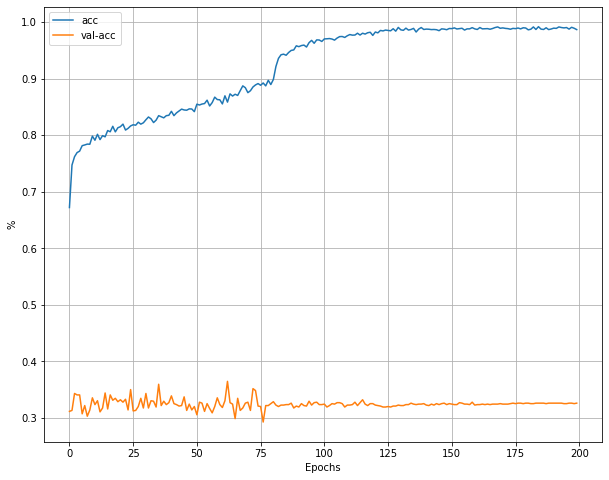

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

In [ ]:
model.save('resnet20Diamant.model')

INFO:tensorflow:Assets written to: resnet20Diamant.model/assets


In [ ]:
model = tf.keras.models.load_model("resnet20Diamant.model")
prediction = model.predict(x_test)

In [ ]:
with np.printoptions(threshold=np.inf):
    print(prediction)

[[1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.    0.001 0.999]
 [0.    0.013 0.987]
 [0.    0.    1.   ]
 [0.    0.991 0.009]
 [0.    0.222 0.778]
 [0.001 0.821 0.177]
 [0.991 0.    0.009]
 [0.581 0.419 0.   ]
 [0.    0.002 0.998]
 [0.013 0.122 0.865]
 [0.028 0.001 0.972]
 [0.003 0.002 0.995]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.037 0.002 0.961]
 [0.001 0.969 0.03 ]
 [0.    0.09  0.91 ]
 [0.    0.485 0.515]
 [1.    0.    0.   ]
 [0.    0.999 0.001]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    0.999 0.001]
 [1.    0.    0.   ]
 [0.    0.019 0.981]
 [1.    0.    0.   ]
 [0.999 0.    0.001]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [0.    0.779 0.221]
 [0.104 0.    0.896]
 [0.833 0.164 0.003]
 [0.    0.97  0.03 ]
 [1.    0.    0.   ]
 [0.    0.061 0.939]
 [0.    0.001 0.999]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    0.007 0.993]
 [1.    0.    0.   ]
 [0.    0.967

In [ ]:
label_pred = np.array([np.argmax(prediction, axis=1)])

In [ ]:
print(label_pred.T)

[[0]
 [0]
 [1]
 ...
 [2]
 [2]
 [1]]


In [ ]:
predict_labels = np.array(test_labels.drop(['class_id'],axis=1))
predict_labels = np.append(predict_labels,label_pred.T,axis=1)
with np.printoptions(threshold=np.inf):
    print(predict_labels)

[['img_6309102362127931879.jpg' 0]
 ['img_2031896927656989520.jpg' 0]
 ['img_4693592482016108254.jpg' 1]
 ['img_1731353163814999872.jpg' 2]
 ['img_4270405616056570211.jpg' 2]
 ['img_5592512817605259347.jpg' 2]
 ['img_7270920511344208641.jpg' 1]
 ['img_8750976362013359084.jpg' 2]
 ['img_3099813306519204140.jpg' 1]
 ['img_6152245361589836720.jpg' 0]
 ['img_5133964404089301517.jpg' 0]
 ['img_6094498399694976619.jpg' 2]
 ['img_5009290568007555183.jpg' 2]
 ['img_91583952582106774.jpg' 2]
 ['img_6172231491103496150.jpg' 2]
 ['img_7279243678066448832.jpg' 0]
 ['img_1508041442905435888.jpg' 0]
 ['img_5834118063979502391.jpg' 2]
 ['img_6587768937848096651.jpg' 1]
 ['img_3077954441619156589.jpg' 2]
 ['img_3655945510172717944.jpg' 2]
 ['img_3153198158239991036.jpg' 0]
 ['img_8068040535899796305.jpg' 1]
 ['img_785206936656049715.jpg' 0]
 ['img_4635476933370359163.jpg' 1]
 ['img_7081409369711501166.jpg' 1]
 ['img_8166760919851749947.jpg' 0]
 ['img_8669652425730035268.jpg' 0]
 ['img_7169925662333297

In [ ]:
df_for_export = pd.DataFrame(predict_labels,columns=['file_name', 'class_id'])

df_for_export.to_csv('resnet20Diamantaras.csv')

In [ ]:
print(df_for_export)

                        file_name class_id
0     img_6309102362127931879.jpg        0
1     img_2031896927656989520.jpg        0
2     img_4693592482016108254.jpg        1
3     img_1731353163814999872.jpg        2
4     img_4270405616056570211.jpg        2
...                           ...      ...
1163  img_3751188215019143871.jpg        1
1164  img_2990304631921044895.jpg        1
1165  img_4362101259165710930.jpg        2
1166   img_972668160331506727.jpg        2
1167  img_7789226562806226056.jpg        1

[1168 rows x 2 columns]
